In [1]:
%matplotlib inline

#from qiskit import IBMQ
#IBMQ.enable_account("8f203c4208b9dead9b422689ba9bc8407df7dfa6d397bad3eac2a68dba4a4c13bea3e4e13399d56cbdbc00abdbb8ecea130002e29ebad954793aa81f1d7bb166")

import numpy as np
import cmath

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, CnotGate, XGate
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries and configuring account
import numpy as np
from math import pi
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

#plotting tools:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
from pd_base import *

In [3]:
#qr = QuantumRegister(2)
#cr = ClassicalRegister(2)

qc = QuantumCircuit(2, 2)

print(create_entangle_matrix(cmath.pi/2));
print(create_entangle_matrix(cmath.pi/2).item(0,3));

[[0.70710678-0.j         0.        +0.j         0.        +0.j
  0.        +0.70710678j]
 [0.        +0.j         0.70710678-0.j         0.        -0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        -0.70710678j 0.70710678-0.j
  0.        +0.j        ]
 [0.        +0.70710678j 0.        +0.j         0.        +0.j
  0.70710678-0.j        ]]
0.7071067811865475j


In [4]:
J = create_entangle_matrix(cmath.pi/2)
dentangle = Operator(J.getH())# gets complex conj transpose
entangle = Operator(J)

In [5]:
alice_strat = Operator(create_strategy_matrix(cmath.pi/2,cmath.pi/2 )) 
bob_strat = Operator(create_strategy_matrix(0, 0)) 

In [6]:
# Set up the circuit

qc.append(entangle, [0, 1])
qc.append(bob_strat, [0])
qc.append(bob_strat, [1])
qc.append(dentangle, [0, 1])

qc.measure([0, 1], [0, 1])

In [7]:
qc.draw()

In [8]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000).result()
counts = job.get_counts(0)

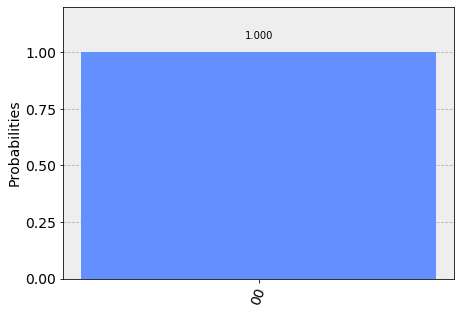

In [9]:
plot_histogram(counts)

In [10]:
ALICE_PAY = {
    '00': 3,
    '01': 5,
    '10': 0,
    '11': 1
}
BOB_PAY = {
    '00': 3,
    '01': 0,
    '10': 5,
    '11': 1
}

def get_payoff(counts, payoffs):
    # returns the expected payoff given a dict of counts for each result: [00, 01, 10, 11]
    # and a dict of payoffs for each result
    
    expected_payoff = 0
    total = 0
    for outcome in counts:
        expected_payoff += counts[outcome] * payoffs[outcome]
        total += counts[outcome]
    
    return expected_payoff / total

3.0


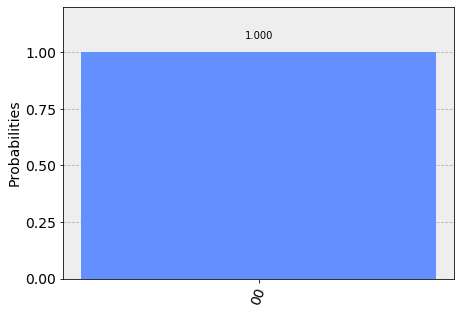

In [11]:
def run_game(atheta,aphi,btheta,bphi,gamma):
    pris_del = QuantumCircuit(2, 2)

    J_op = Operator(create_entangle_matrix(gamma))
    J_op_dagger = Operator(create_entangle_matrix(gamma).getH())

    pris_del.append(J_op, [0, 1])
    pris_del.append(Operator(create_strategy_matrix(atheta,aphi)), [0])
    pris_del.append(Operator(create_strategy_matrix(btheta,bphi)), [1])
    pris_del.append(J_op_dagger, [0, 1])

    pris_del.measure([0, 1], [0, 1])

    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(pris_del, backend, shots=1000).result()
    counts = job.get_counts(0)
    
    return (counts,pris_del)

pi = cmath.pi    
counts, pris_del = run_game(0,0,0,0,0)
print(get_payoff(counts, ALICE_PAY))
plot_histogram(counts)

In [12]:
build_game_circuit(create_strategy_matrix(0,0), create_strategy_matrix(cmath.pi, cmath.pi), .5)

In [13]:
counts

{'00': 1000}

In [14]:
pris_del.draw()

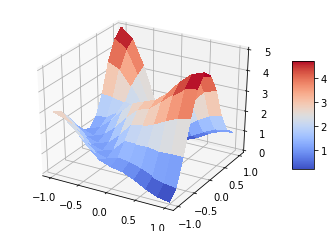

In [15]:
def aPaySurface(steps,gamma):
    #init 3D plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    stepSize = 2/steps
    At = np.arange(-1,1+stepSize,stepSize)
    Bt = np.arange(-1,1+stepSize,stepSize)
    At, Bt = np.meshgrid(At,Bt)
    Z = np.zeros([steps+1,steps+1])
    
    for index_tb in range(steps+1):
        for index_ta in range(steps+1):
            #normalize to [-1,1]
            tb = (stepSize*index_tb) - 1
            ta = (stepSize*index_ta) - 1
            
            #implements piecewise parameterization used in EWG games paper
            if tb < 0:
                btheta = 0
                bphi = (-cmath.pi/2)*tb
            else:
                btheta = cmath.pi*tb
                bphi = 0
                
            if ta < 0:
                atheta = 0
                aphi = (-cmath.pi/2)*ta
            else:
                atheta = cmath.pi*ta
                aphi = 0
            
            counts, tmp = run_game(atheta,aphi,btheta,bphi,gamma)
            Z[index_tb,index_ta] = get_payoff(counts, ALICE_PAY)
            
    # Plot the surface.
    surf = ax.plot_surface(At, Bt, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    """
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    """
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    """
    print(Z)
    print(At)
    print(Bt)
    """
    plt.show()

aPaySurface(10,cmath.pi/2)

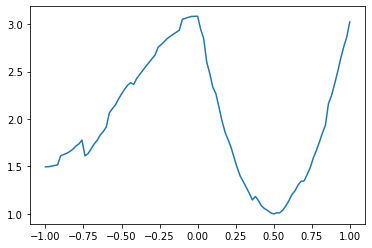

In [16]:
def aPayPlot(steps, atheta, aphi, gamma):
    stepSize = 2/steps
    Bt = np.arange(-1,1+stepSize,stepSize)
    Y = np.zeros([steps+1])
    
    for index_tb in range(steps+1):
            #normalize to [-1,1]
            tb = (stepSize*index_tb) - 1
            
            #implements piecewise parameterization used in EWG games paper
            if tb < 0:
                btheta = 0
                bphi = (-cmath.pi/2)*tb
            else:
                btheta = cmath.pi*tb
                bphi = 0
                
            counts, tmp = run_game(atheta,aphi,btheta,bphi,gamma)
            Y[index_tb] = get_payoff(counts, ALICE_PAY)
    
    plt.plot(Bt,Y)     
    plt.show()

aPayPlot(100,cmath.pi/2,cmath.pi/2,cmath.pi/2)